## GENERAL SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.planets import PlanetModel

## PLOT SETUP

In [4]:
print(
    "TODO: CREATE GALLIFREY FUNCTION FOR PLOT LABEL RENAMING, COLOR MAPS, SAVING FUNCTION (NAMES AND GALLIFREY PATH, MAYBE SEPERATE SAVE FUNCTION AS PART OF GALLIFREY THAT TAKES FIG OBJECT), PAIR PLOT DIAGONALS AND CORNERS, INT VALUES IN COLORBAR LABEL"
)
print("CHANGES WITH MASS, (NUMBER OF PLANETS, CHANGES IN CORRELATIONS)")

TODO: CREATE GALLIFREY FUNCTION FOR PLOT LABEL RENAMING, COLOR MAPS, SAVING FUNCTION (NAMES AND GALLIFREY PATH, MAYBE SEPERATE SAVE FUNCTION AS PART OF GALLIFREY THAT TAKES FIG OBJECT), PAIR PLOT DIAGONALS AND CORNERS, INT VALUES IN COLORBAR LABEL
CHANGES WITH MASS, (NUMBER OF PLANETS, CHANGES IN CORRELATIONS)


In [5]:
sns.set(rc={"figure.figsize": (18.5, 10.5)})
sns.set_style("whitegrid", {"axes.grid": False})
sns.set_palette("pastel")

In [6]:
print(
    "Make this a function that only maps the values actually found in dataframe and returns corresponding labels"
)
label_mapping = {
    "log_initial_mass": r"log $M_\mathrm{g}$",
    "[Fe/H]": "[Fe/H]",
    "log_photoevaporation": r"log $\dot{M}_\mathrm{wind}$",
    "log_inner_edge": r"log $r_\mathrm{in}$",
}
labels = list(label_mapping.values())

Make this a function that only maps the values actually found in dataframe and returns corresponding labels


## ORIGINAL SAMPLE (HOST STAR MASS = 1)

### Setup Variables and Planet Model

In [7]:
num_embryos = 50
host_star_mass = 1
age = int(1e8)

planet_model = PlanetModel(num_embryos)

population_id = planet_model.get_population_id(num_embryos, host_star_mass)

categories = [
    category
    for category in planet_model.categories
    if category not in ["Dwarf", "D-Burner"]
]

### Recreate Original Sample (needs neighbors=1, to actuall re-create original data)

In [8]:
original_variables = planet_model.get_systems(population_id).variables
original_variables["age"] = age
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    return_full=True,
    neighbors=1,
)

In [9]:
original_sample = original_sample.rename(columns=label_mapping)

### Pair Plot (variations for one planet category with variables)

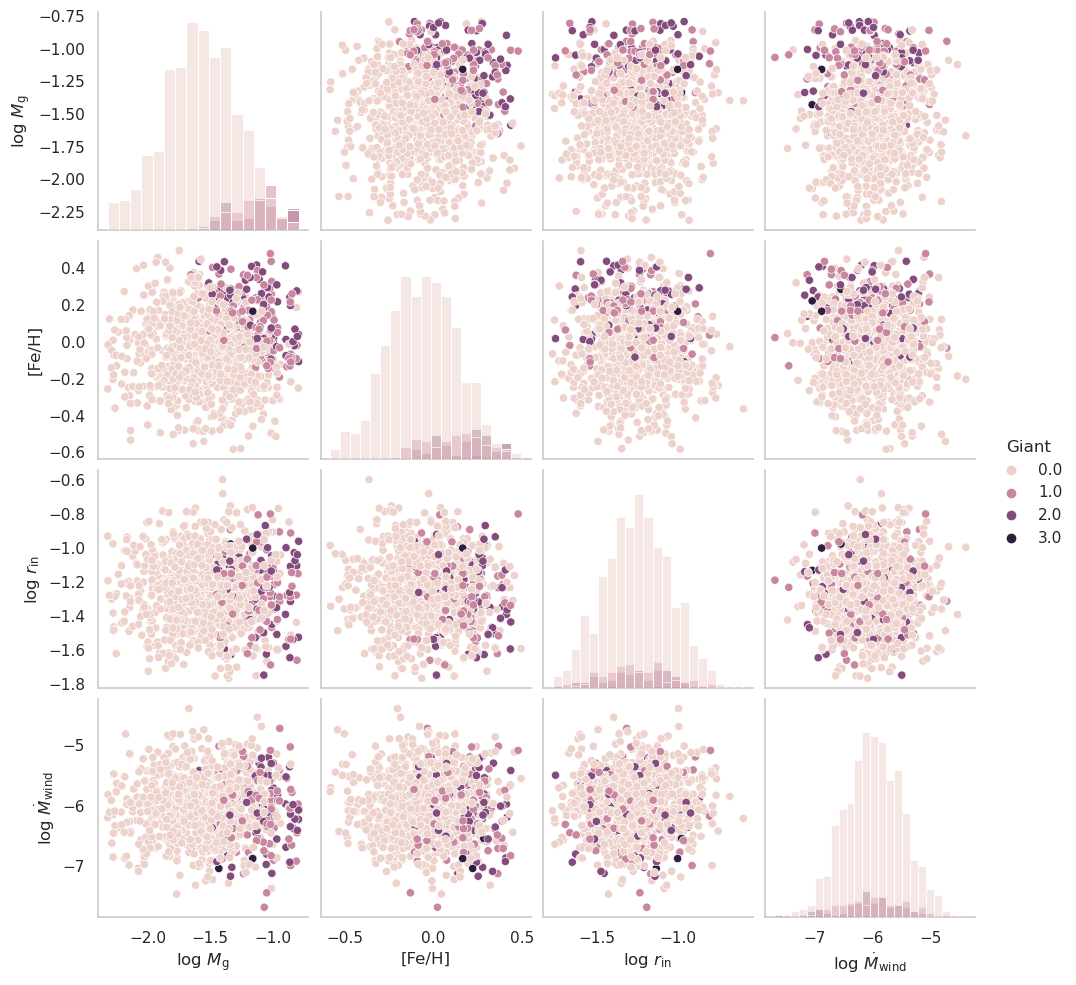

In [13]:
planet_type = "Giant"
pair_plot = sns.pairplot(
    original_sample.drop(columns=["age", *[c for c in categories if c != planet_type]]),
    hue=planet_type,
    diag_kind="hist",
)

### Correlation plot between Planet Types and Variables (Kendall Tau correlation coefficent)

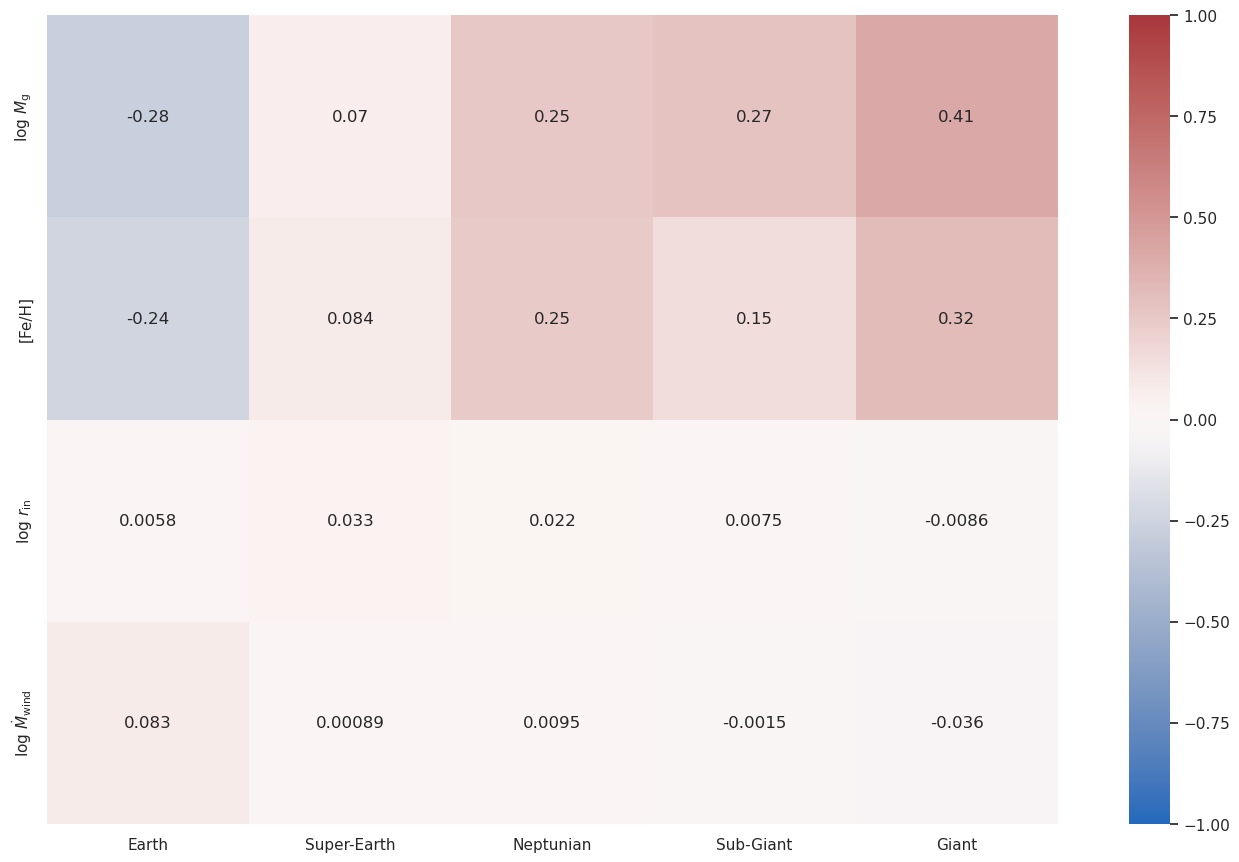

In [12]:
correlation_matrix = original_sample.corr(method="kendall").drop(
    columns=["age", *labels], index=["age", *categories]
)
correlation_plot = sns.heatmap(
    correlation_matrix, vmin=-1, vmax=1, square=True, annot=True, cmap="vlag"
)